# **Redes Neurais Artificiais**

Exemplo de uma MLP (Multi-Layer Perceptron):

<img src="https://github.com/OviedoVR/ML_especializacao/blob/main/assets/ann_mlp_illustration.png?raw=true" width="70%"/>

Fonte: ELGENDY, Mohamed. **Deep Learning for Vision Systems**. Shelter Island: Manning Publications, 2020

<br>

> **PROBLEMA DE NEGÓCIO:** uma empresa de cursos preparatórios busca prever a performance de seus estudantes em um exame de certificação e, com isso, propor ações e estratégias para promover uma maior taxa de aprovação. Para isso, tem-se dados históricos contendo `horas de estudo`, `horas de sono`, `atividades extracurriculares (s/n)`, `número de questões praticadas`, `notas anteriores` e `nota final (performance)`.

In [1]:
# -- Manipulação de dados:
import pandas as pd

# -- DataViz:
import matplotlib.pyplot as plt
import seaborn as sns

# -- Pré-processamento:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# RNA:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Processamento sem alocar 100% da GPU:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## **Coleta de dados e EDA**

In [2]:
!wget -q 'https://raw.githubusercontent.com/OviedoVR/ML_especializacao/main/dados/student_performance.csv' -O 'student_performance.csv'

In [3]:
# dados:
dados = pd.read_csv('student_performance.csv')
dados.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [4]:
# amostra
dados = dados.sample(n=5000, random_state=42)
dados.shape

(5000, 6)

In [5]:
# tamanho do dataset:
dados.shape

(5000, 6)

In [6]:
# tipos de dado:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6252 to 2764
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     5000 non-null   int64  
 1   Previous Scores                   5000 non-null   int64  
 2   Extracurricular Activities        5000 non-null   object 
 3   Sleep Hours                       5000 non-null   int64  
 4   Sample Question Papers Practiced  5000 non-null   int64  
 5   Performance Index                 5000 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 273.4+ KB


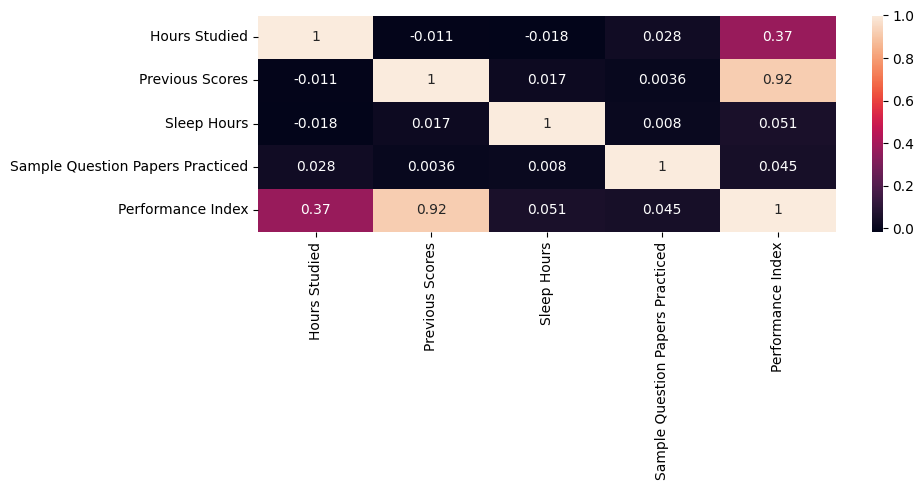

In [7]:
# Matriz de correlação:
dados_col_numericas = dados.select_dtypes(include='number')
fig, ax = plt.subplots(figsize=(10,5));
sns.heatmap(dados_col_numericas.corr(), annot=True);
plt.tight_layout();

Comentário:

* A coluna `Sample Question Papers Practiced` parece ter uma correlação fraca com a resposta (`Performance Index`), logo, iremos retirá-la da análise.

## **Modelagem: Regressão**

In [8]:
# ordem das colunas:
dados = dados[[
    'Hours Studied',
    'Sleep Hours',
    'Extracurricular Activities',
    'Previous Scores',
    'Performance Index'
]]

# resultado:
dados.head()

,Hours Studied,Sleep Hours,Extracurricular Activities,Previous Scores,Performance Index
6252,5,8,No,69,51.0
4684,2,4,Yes,46,20.0
1731,7,7,Yes,56,46.0
4742,6,8,Yes,42,28.0
4521,7,4,No,53,41.0


In [9]:
# amostra:
#dados = dados.sample(n=3000, random_state=42)
#dados.shape

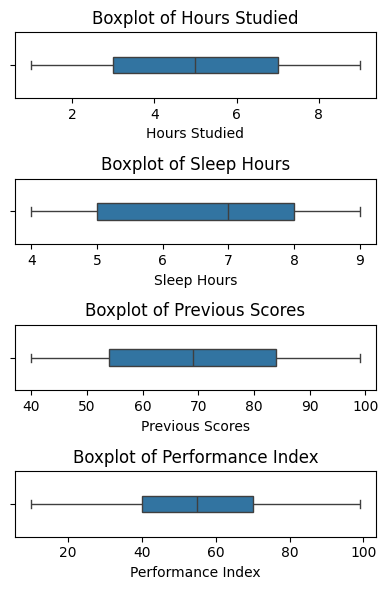

In [10]:
# Filtra colunas numéricas
num_cols = dados.select_dtypes(include=['number']).columns

# Cria uma figura
plt.figure(figsize=(4, len(num_cols) * 1.5))

# Loop para gerar boxplots
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i + 1)
    sns.boxplot(data=dados, x=col, width=0.25)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

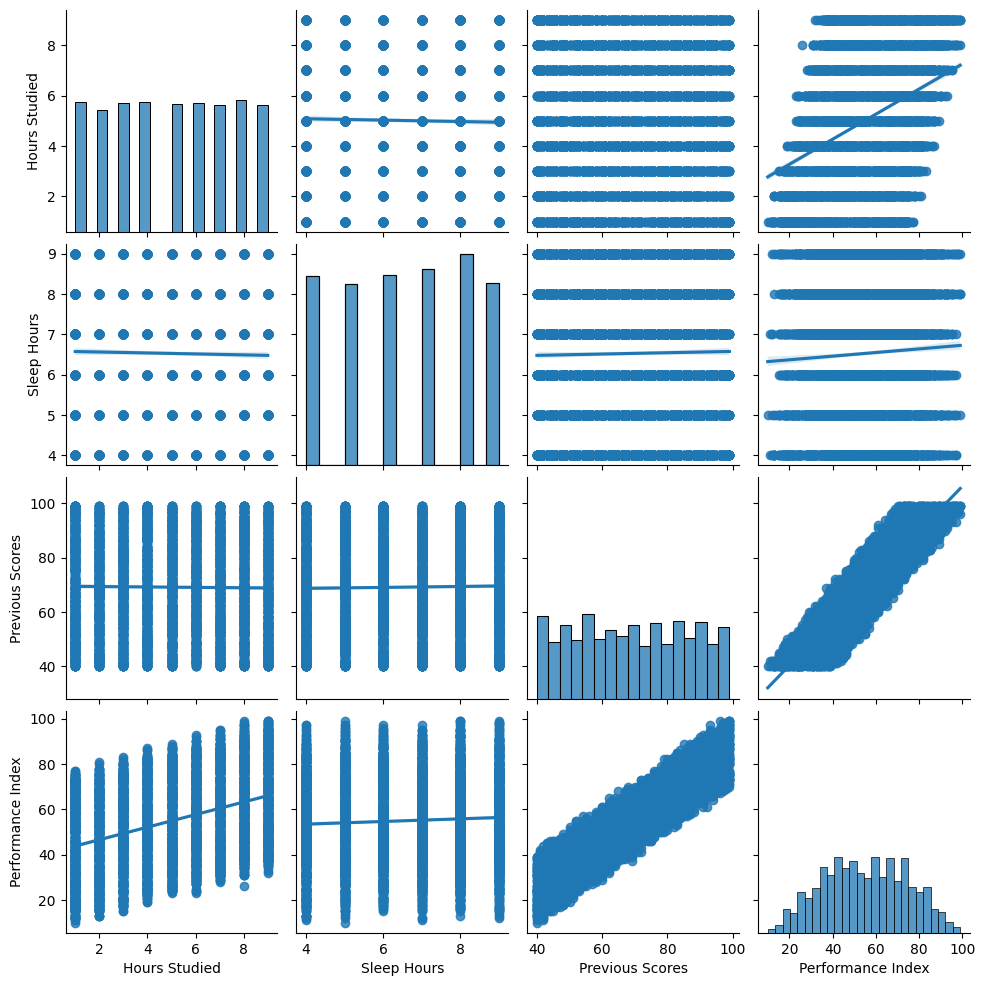

In [11]:
sns.pairplot(dados, kind='reg');

In [12]:
# codificação de variáveis categóricas:
dados['Extracurricular Activities'] = dados['Extracurricular Activities'].replace('No', 0).replace('Yes', 1)

In [13]:
# Variáveis de entrada:
x = dados.drop(['Performance Index'], axis=1).to_numpy()
y = dados['Performance Index'].to_numpy()

# Treino/teste
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3,random_state=42)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [14]:
# Scaling para features (x)
scaler_x = StandardScaler()

# Ajustar o scaler para os dados de treinamento e transformar
xtrain_std = scaler_x.fit_transform(xtrain)  # Ajusta e transforma
xtest_std = scaler_x.transform(xtest)        # Apenas transforma

# Scaling para variável resposta (y), se necessário
scaler_y = StandardScaler()

# Ajustar o scaler para a variável resposta de treinamento e transformar
ytrain_std = scaler_y.fit_transform(ytrain.reshape(-1, 1))  # Ajusta e transforma
ytest_std = scaler_y.transform(ytest.reshape(-1, 1))        # Apenas transforma

**Estruturando a RNA do tipo MLP**

1. Define uma RNA sequencial
2. Define camadas 1-n (densas)
3. Define camada oculta
4. Define parâmetros de compliação do modelo
5. Resumo

In [15]:
# Criação do modelo (camada de entrada com n features (dimensões), 1 camada oculta com 6 neurônios, 1 neurônio na camada de saída):
model = keras.Sequential()

# Camada 1:
model.add(layers.Dense(6,
                                        input_dim=xtrain_std.shape[1],
                                        activation='relu',
                                        kernel_regularizer=keras.regularizers.l1_l2()))

# Camada de saída:
model.add(layers.Dense(1))

# Compilação do Modelo
model.compile(loss='mean_squared_error',
                         optimizer=keras.optimizers.Adam(),
                         metrics=[tf.keras.metrics.R2Score])

# Resumo:
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

> **Documentação Keras**

* Loss: https://keras.io/api/losses/
* Metrics: https://keras.io/api/metrics/

> Nota:

* $R^2$, accuracy: `max`
* MAE, MSE, RMSE, entropy: `min`

**Avaliação da RNA antes de treinar o modelo**

In [16]:
score_train, metric_train = model.evaluate(xtrain_std, ytrain_std, verbose=0)
score_test, metric_test = model.evaluate(xtest_std, ytest_std, verbose=0)

print(f'R² no conjunto de treino: {round(metric_train*100, 1)}%')
print(f'R² no conjunto de teste: {round(metric_test*100, 1)}%')

R² no conjunto de treino: -60.3%
R² no conjunto de teste: -58.6%


**Predições**

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0, 0.5, 'Y predito')

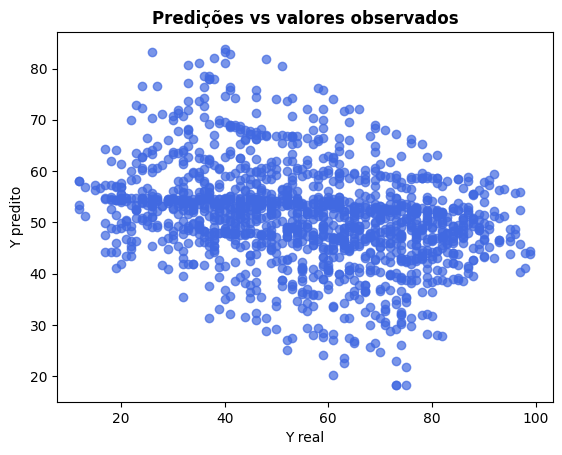

In [17]:
# Predições
ytrain_pred = scaler_y.inverse_transform(model.predict(xtrain_std))
ytest_pred = scaler_y.inverse_transform(model.predict(xtest_std))

fig, ax = plt.subplots()
plt.plot(ytest, ytest_pred, 'o', color='royalblue', alpha=0.7)
plt.title('Predições vs valores observados', weight='bold')
plt.xlabel('Y real')
plt.ylabel('Y predito')

**Treino da Rede Neural**

In [18]:
rna_earlystop = keras.callbacks.EarlyStopping(
    monitor="val_r2_score",
    min_delta=0.01,
    patience = 20,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

historico = model.fit(
    x=xtrain_std,
    y=ytrain_std,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=rna_earlystop
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3991 - r2_score: -0.4808 - val_loss: 1.0527 - val_r2_score: -0.0888
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0074 - r2_score: -0.0348 - val_loss: 0.7345 - val_r2_score: 0.2403
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7340 - r2_score: 0.2754 - val_loss: 0.4523 - val_r2_score: 0.5322
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4217 - r2_score: 0.5809 - val_loss: 0.2277 - val_r2_score: 0.7645
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2275 - r2_score: 0.7798 - val_loss: 0.1121 - val_r2_score: 0.8841
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1022 - r2_score: 0.8982 - val_loss: 0.0696 - val_r2_score: 0.9280
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0694 - r2_score: 0.9320 - val_loss: 0.0557 - val_r2_score: 0.9424
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0521 - r2_score: 0.9448 - val_loss: 0.0483 - va

**Desempenho**

In [19]:
score_train, metric_train = model.evaluate(xtrain_std, ytrain_std, verbose=0)
score_test, metric_test = model.evaluate(xtest_std, ytest_std, verbose=0)

print(f'R² no conjunto de treino: {round(metric_train*100, 1)}%')
print(f'R² no conjunto de teste: {round(metric_test*100, 1)}%')

R² no conjunto de treino: 97.7%
R² no conjunto de teste: 97.7%


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0, 0.5, 'Y predito')

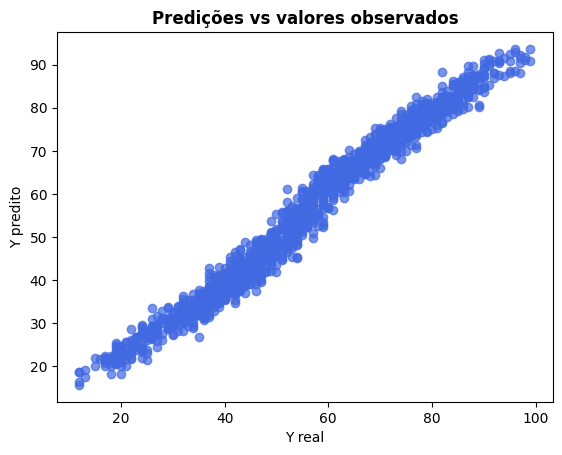

In [20]:
# Predições
ytrain_pred = scaler_y.inverse_transform(model.predict(xtrain_std))
ytest_pred = scaler_y.inverse_transform(model.predict(xtest_std))

fig, ax = plt.subplots()
plt.plot(ytest, ytest_pred, 'o', color='royalblue', alpha=0.7)
plt.title('Predições vs valores observados', weight='bold')
plt.xlabel('Y real')
plt.ylabel('Y predito')

In [21]:
historico.history.keys()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])

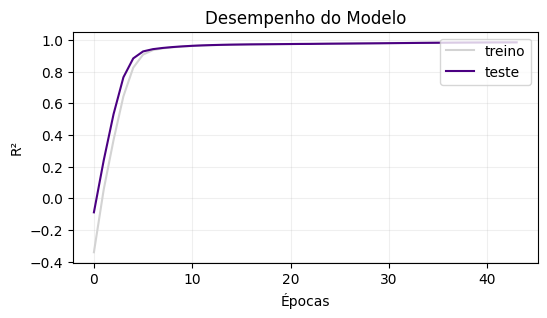

In [22]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['r2_score'], color='lightgray', label='treino')
plt.plot(historico.history['val_r2_score'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('R²')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

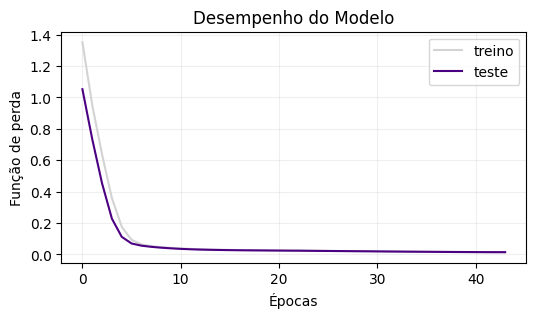

In [23]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['loss'], color='lightgray', label='treino')
plt.plot(historico.history['val_loss'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('Função de perda')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

* Fazendo uma predição pontual:

In [24]:
ytest_raw = scaler_y.inverse_transform(ytest_std)

print(f'Valores y (real)\n{ytest_raw[0:5]}')
print('---'*10)
print(f'Valores de y (predito)\n{ytest_pred[0:5]}')

Valores y (real)
[[59.]
 [51.]
 [61.]
 [44.]
 [77.]]
------------------------------
Valores de y (predito)
[[63.714516]
 [52.470596]
 [61.506824]
 [43.784126]
 [73.54373 ]]


In [25]:
residuos = ytest_raw - ytest_pred
print('Resíduo')
print('---'*10)
print(residuos[0:5])

Resíduo
------------------------------
[[-4.71451569]
 [-1.47059631]
 [-0.50682449]
 [ 0.21587372]
 [ 3.45626831]]


**Análise dos Resíduos**



<ipython-input-26-04fec5e2222b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1);


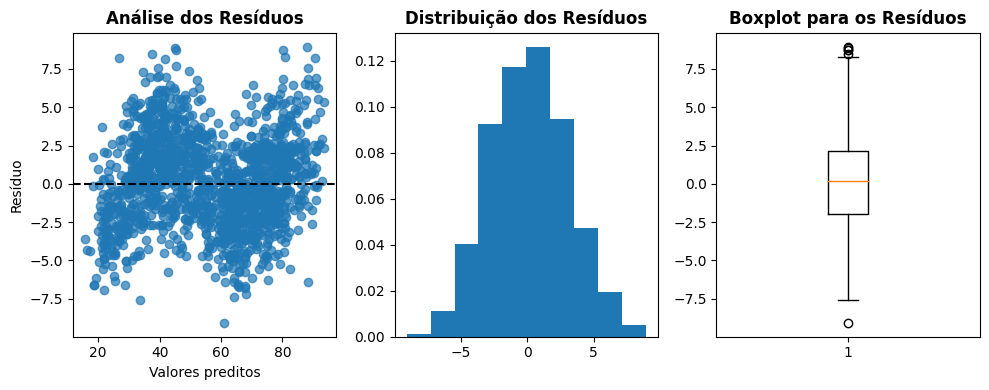

In [26]:
fig, ax = plt.subplots(figsize=(10,4));

# Sub-gráfico 1:
plt.subplot(1,3,1);
plt.title('Análise dos Resíduos', weight='bold')
plt.plot(ytest_pred, residuos, 'o', alpha=0.7);
plt.axhline(y=0, lw=1.5, ls='--', color='black');
plt.xlabel('Valores preditos')
plt.ylabel('Resíduo')

# Sub-gráfico 2:
plt.subplot(1,3,2);
plt.title('Distribuição dos Resíduos', weight='bold')
plt.hist(residuos, density = True, histtype ='barstacked');

# Sub-gráfico 3:
plt.subplot(1,3,3);
plt.title('Boxplot para os Resíduos', weight='bold')
plt.boxplot(residuos);
plt.tight_layout();

Ideal:

* Não possuir padrões no gráfico 1 (**dispersão** de valores preditos *versus* resíduos) e distribuição aleatória em torno de zero.
* Distribuição normal (gráfico 2 - **histograma**)
* Poucos outliers (gráfico 3 - **boxplot**)

> **Outro exemplo de Regressão** (documentação do Tensoflow): https://www.tensorflow.org/tutorials/keras/regression?hl=pt-br

## **Modelagem: Classificação**

In [27]:
# Obtendo classes como resposta (1: aprovado, 0: reprovado):
dados['Performance Index'] = dados['Performance Index'].apply(lambda registro: 1 if registro >= 70 else 0)

# Variáveis de entrada:
x = dados.drop('Performance Index', axis=1).to_numpy()
y = dados['Performance Index'].to_numpy()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3,random_state=42)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [28]:
# Scaling para features (x)
scaler_x = StandardScaler()

# Ajustar o scaler para os dados de treinamento e transformar
xtrain_std = scaler_x.fit_transform(xtrain)  # Ajusta e transforma
xtest_std = scaler_x.transform(xtest)        # Apenas transforma

**Estruturando a RNA do tipo MLP**

1. Define uma RNA sequencial
2. Define camadas 1-n (densas)
3. Define camada oculta
4. Define parâmetros de compliação do modelo
5. Resumo

In [29]:
# Criação do modelo (camada de entrada com n features (dimensões), 1 camada oculta com 6 neurônios, 1 neurônio na camada de saída):
model = keras.Sequential()

# Camada 1:
model.add(layers.Dense(6,
                                        input_dim=xtrain_std.shape[1],
                                        activation='tanh'))

# Caso queira camda de dropout:
#model.add(layers.Dropout(0.2))

# Camada de saída:
model.add(layers.Dense(1, activation='sigmoid'))

# Compilação do Modelo
model.compile(loss='binary_crossentropy',
                         optimizer=keras.optimizers.Adam(),
                         metrics=[keras.metrics.AUC(name='auc')])

# Resumo:
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 6)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

> **Documentação Keras**

* Loss: https://keras.io/api/losses/
* Metrics: https://keras.io/api/metrics/

> Nota:

* $R^2$, accuracy: `max`
* MAE, MSE, RMSE, entropy: `min`

**Treino da Rede Neural**

In [30]:
rna_earlystop = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    min_delta=0.01,
    patience = 20,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

historico = model.fit(
    x=xtrain_std,
    y=ytrain,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[rna_earlystop]
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc: 0.8517 - loss: 0.5785 - val_auc: 0.9265 - val_loss: 0.4944
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9547 - loss: 0.4542 - val_auc: 0.9719 - val_loss: 0.3947
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9800 - loss: 0.3686 - val_auc: 0.9860 - val_loss: 0.3230
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9919 - loss: 0.2952 - val_auc: 0.9912 - val_loss: 0.2703
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9948 - loss: 0.2540 - val_auc: 0.9932 - val_loss: 0.2317
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9972 - loss: 0.2164 - val_auc: 0.9945 - val_loss: 0.2030
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9971 - loss: 0.1878 - val_auc: 0.9948 - val_loss: 0.1812
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9980 - loss: 0.1673 - val_auc: 0.9950 - val_loss: 0.1642
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9976

**Desempenho**

In [31]:
score_train, metric_train = model.evaluate(xtrain_std, ytrain, verbose=0)
score_test, metric_test = model.evaluate(xtest_std, ytest, verbose=0)

print(f'AUC no conjunto de treino: {round(metric_train*100, 1)}%')
print(f'AUC no conjunto de teste: {round(metric_test*100, 1)}%')

AUC no conjunto de treino: 98.9%
AUC no conjunto de teste: 99.1%


In [32]:
historico.history.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

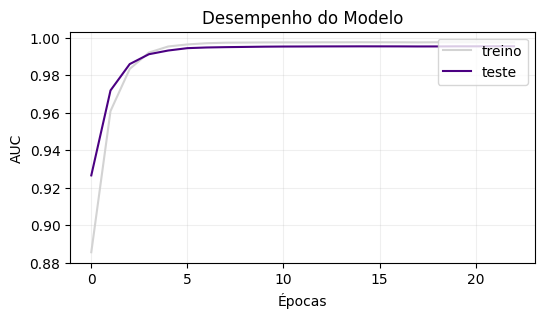

In [33]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['auc'], color='lightgray', label='treino')
plt.plot(historico.history['val_auc'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('AUC')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

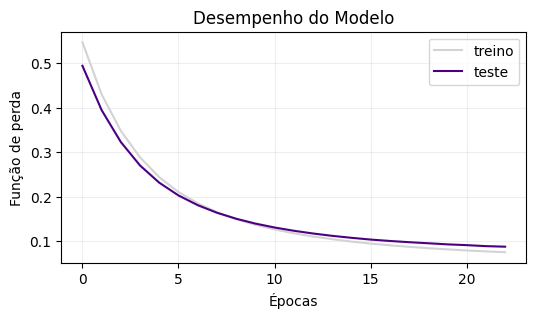

In [34]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['loss'], color='lightgray', label='treino')
plt.plot(historico.history['val_loss'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('Função de perda')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

* Fazendo uma predição pontual:

In [35]:
# Predições para o conjunto de teste
ytest_pred_prob = model.predict(xtest_std)

# Convertendo probabilidades em classes (0 ou 1) usando um limiar de 0.7
ytest_pred_class = (ytest_pred_prob > 0.7).astype(int)

# Exibindo os valores reais e preditos
print(f'Valores y (real)\n{ytest[0:5]}')  # ytest contém as classes reais (0 ou 1)
print('---' * 10)
print(f'Valores de y (predito - probabilidades)\n{ytest_pred_prob[0:5]}')  # Probabilidades preditas
print('---' * 10)
print(f'Valores de y (predito - classes)\n{ytest_pred_class[0:5]}')  # Classes preditas (0 ou 1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Valores y (real)
[0 0 0 0 1]
------------------------------
Valores de y (predito - probabilidades)
[[0.41240185]
 [0.3025803 ]
 [0.46575317]
 [0.17779791]
 [0.6770841 ]]
------------------------------
Valores de y (predito - classes)
[[0]
 [0]
 [0]
 [0]
 [0]]


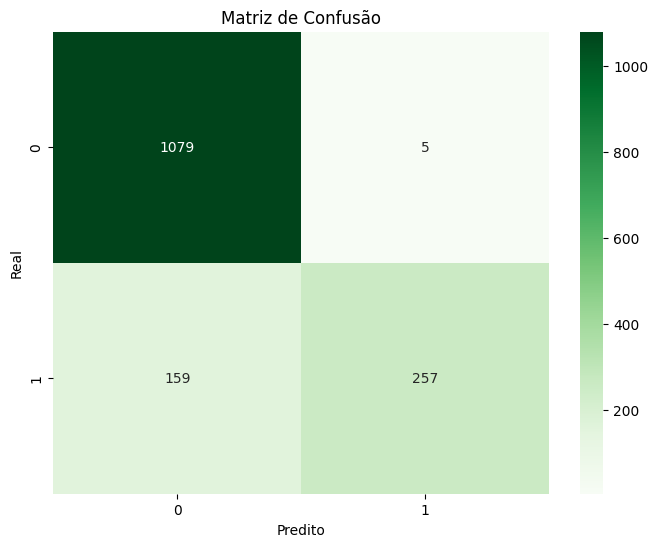

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Gerando a matriz de confusão:
confusion_matrix = confusion_matrix(ytest, ytest_pred_class)

# Visualizando a matriz:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [37]:
# Gerando o relatório de classificação
report = classification_report(ytest, ytest_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1084
           1       0.98      0.62      0.76       416

    accuracy                           0.89      1500
   macro avg       0.93      0.81      0.84      1500
weighted avg       0.90      0.89      0.88      1500



Lembrando:

* **Precision:** foca na qualidade das predições positivas. Útil quando o custo de prever um FP é alto.
* **Recall:** foca em encontrar o maior número possível de positivos reais. É importante quando o custo de um FN é alto.
* **F1-Score:** balanceia os dois, útil quando ambos são igualmente importantes.
* **Acurácia (Accuracy):**  proporção de todas as previsões corretas.